# Disorder Induced Heating Modeled by Molecular Dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from scipy.interpolate import interp1d

from exp_setup import Cylindrical_Grid, Experiment
# from TTM_solver import TwoTemperatureModel
from Hydro_solver import HydroModel


from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
grid  = Cylindrical_Grid(200e-6, N=1000) 
Z, A = 54, 131
Te_initial, Ti_initial = 20e3, 0#16.60952380952381e3, 9.32e3 #[K]
temperature_measurement_width = 20e-6 # [m]
gaussian_FWHM = 100e-6
n0 = 1.25e20 *1e6

dih_file = "/home/zach/plasma/TTM/data/Xe5bar_DIH_profile_data.txt"


# Create Experimental layout and TTM solver
Xenon_jt = Experiment(grid, n0, Z, A, Te_initial, Ti_initial, gaussian_FWHM, temperature_measurement_width,
                      gas_name='Xenon', model = "JT", ion_temperature_model = 'MD',
                      ion_temperature_file=dih_file, electron_temperature_model='gaussian', 
                      Te_experiment_is_peak=True, super_gaussian_power=2)

ttm_jt = HydroModel(Xenon_jt, model = "JT")

# Xenon_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "SMT",
#                       ion_temperature_model = 'gaussian', ion_temperature_file = dih_file)
# ttm_smt = TwoTemperatureModel(Xenon_smt, model = "SMT")

Te_max = 2.000e+04 K


### Save Data 

In [3]:
last_ind = -120
sep = 8

data = np.array([ttm_smt.grid.r[:last_ind][::sep],ttm_smt.Te[:last_ind][::sep], ttm_smt.Zbar[:last_ind][::sep]]).T
data
header_txt = 'r[m]   Te[K]   Zbar '
np.savetxt( "/home/zach/Downloads/DIH_profile_data.txt", data, header=header_txt )

### Load Data

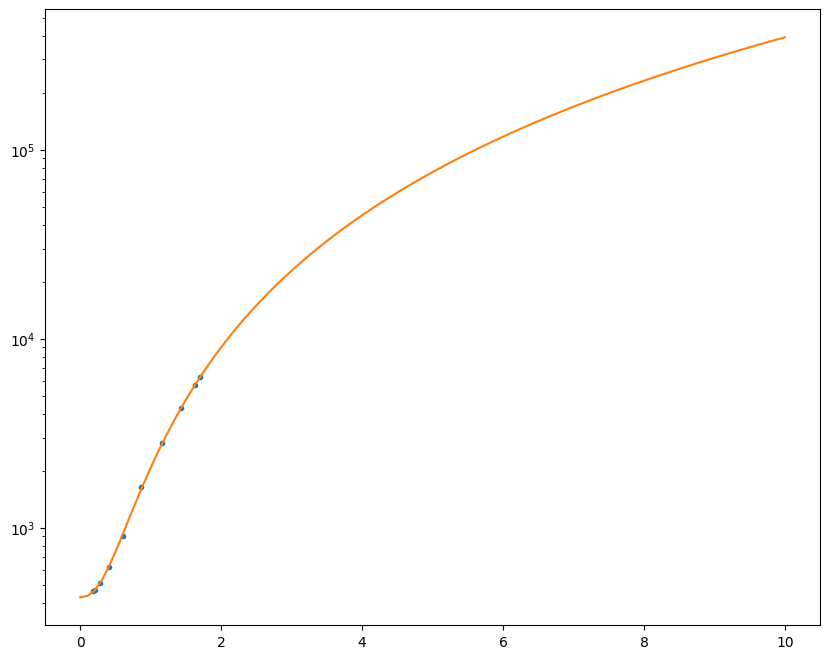

In [20]:
from scipy.optimize import curve_fit

data = read_csv(dih_file, delim_whitespace=True, header=0 )

fig, ax = plt.subplots(figsize=(10,8))

def T_DIH_fit(Zbar, T_room, T_0, pow):
    return T_room + T_0 *Zbar**pow
    
    
fit_vals = curve_fit(T_DIH_fit, data['Zbar'], data['Tion[K]'])[0]
    
Z_list = np.linspace(0,10, num=100)
ax.plot(data['Zbar'], data['Tion[K]'],'.')
ax.plot(Z_list, T_DIH_fit(Z_list, *fit_vals))
ax.set_yscale('log')
# ax.set_xscale('log')

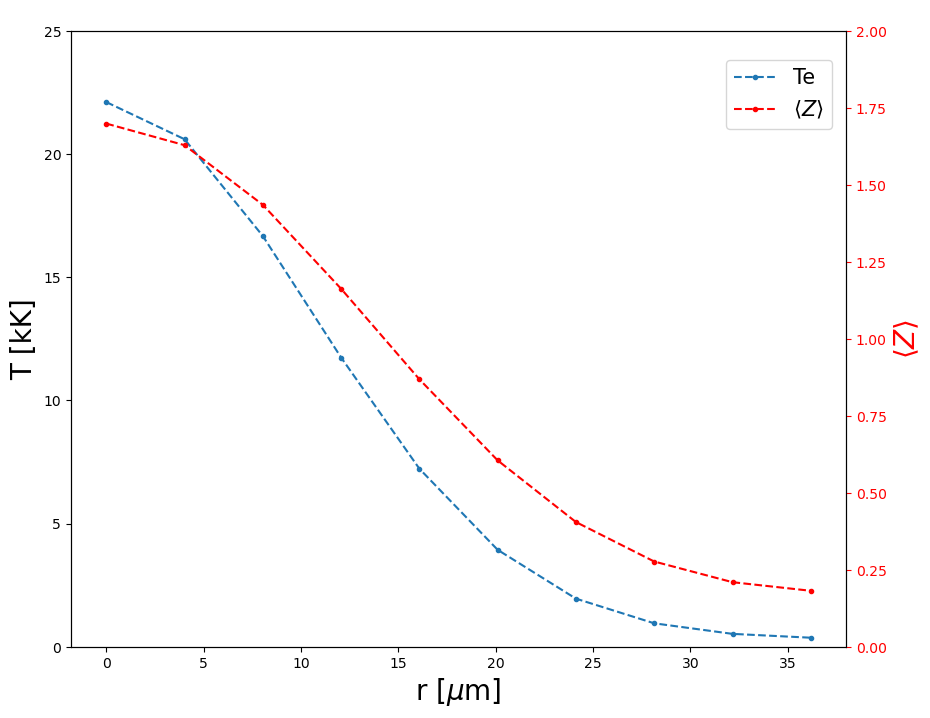

In [5]:
#Save Data for DIH MD

fig, ax = plt.subplots(figsize=(10,8),facecolor='w')

ax.plot(data['r[m]']*1e6, data['Te[K]']*1e-3, '--.', label='Te')
# ax.plot(data['r[m]']*1e6, data['Tion[K]']*1e-3, '--.', label='Ti (MD DIH)')

ax.set_ylabel('T [kK]',fontsize=20)

ax.set_xlabel(r'r [$\mu$m]',fontsize=20)
ax.set_ylim(0,25)
# ax.yaxis.label.set_color(colors[0])
# ax.tick_params(axis='y', colors=colors[0])



ax2 = ax.twinx()
ax2.plot(data['r[m]']*1e6, data['Zbar'], 'r--.', label=r'$\langle Z \rangle $')
ax2.set_ylabel(r'$\langle{Z}\rangle$',fontsize=20)
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')

ax2.set_ylim(0,2)
fig.legend(loc=(0.78,0.82), fontsize=15)

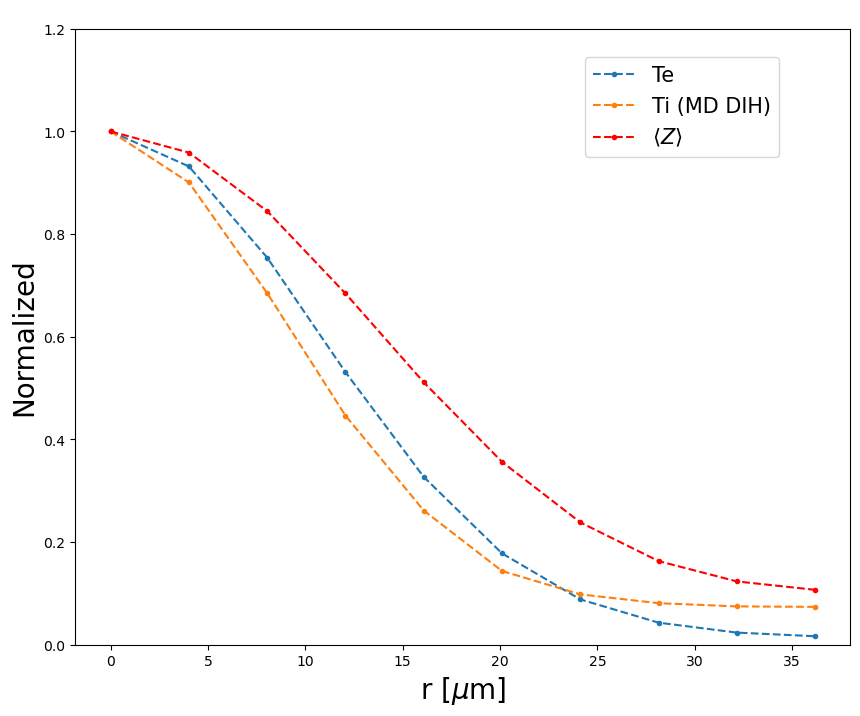

In [6]:
#Save Data for DIH MD

fig, ax = plt.subplots(figsize=(10,8),facecolor='w')

ax.plot(data['r[m]']*1e6, data['Te[K]']/data['Te[K]'][0], '--.', label='Te')
ax.plot(data['r[m]']*1e6, data['Tion[K]']/data['Tion[K]'][0], '--.', label='Ti (MD DIH)')

ax.set_ylabel('Normalized',fontsize=20)

ax.set_xlabel(r'r [$\mu$m]',fontsize=20)
ax.set_ylim(0,25)
# ax.yaxis.label.set_color(colors[0])
# ax.tick_params(axis='y', colors=colors[0])


ax.plot(data['r[m]']*1e6, data['Zbar']/data['Zbar'][0], 'r--.', label=r'$\langle Z \rangle $')

ax.set_ylim(0,1.2)
fig.legend(loc=(0.68,0.78), fontsize=15)

In [7]:
from scipy.optimize import curve_fit

def gaussian_Ti(r, T_peak, T_room, σ ):
    return T_room + T_peak*np.exp(-r**2/(2*σ**2))
    
    
T_peak_fit, T_room_fit, σ_fit = curve_fit(gaussian_Ti, data['r[m]']*1e6, data['Tion[K]']*1e-3 )[0]
T_peak_fit, T_room_fit, σ_fit

(5.790877732799493, 0.46325787148965847, 8.945871581833204)

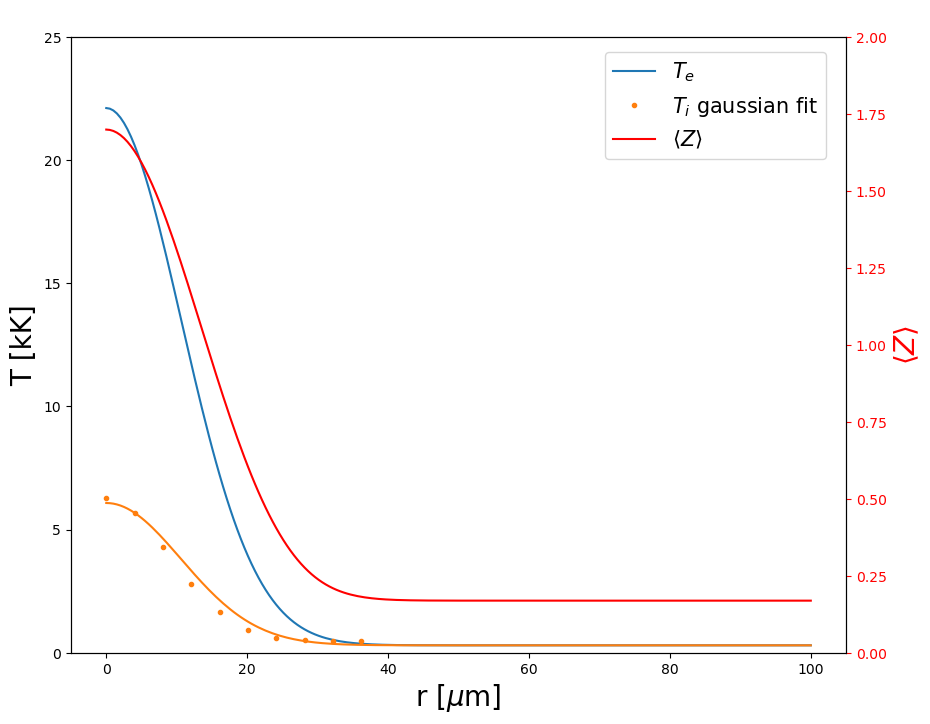

In [8]:
#Save Data for DIH MD

fig, ax = plt.subplots(figsize=(10,8),facecolor='w')

# ax.plot(data['r[m]']*1e6, data['Te[K]']*1e-3, '--.', label='Te')
ax.plot(ttm_smt.grid.r*1e6, ttm_smt.Te*1e-3, label=r'$T_e$')
ax.plot(data['r[m]']*1e6, data['Tion[K]']*1e-3, '.', label=r'$T_i$ gaussian fit')
rs = np.linspace(0,50)
# ax.plot(rs, gaussian_Ti(rs, T_peak_fit, T_room_fit, σ_fit), color=colors[1])
ax.plot(Xenon_smt.grid.r*1e6, Xenon_smt.Ti*1e-3, color=colors[1] )

ax.set_ylabel('T [kK]',fontsize=20)

ax.set_xlabel(r'r [$\mu$m]',fontsize=20)
ax.set_ylim(0,25)
# ax.yaxis.label.set_color(colors[0])
# ax.tick_params(axis='y', colors=colors[0])



ax2 = ax.twinx()
ax2.plot(ttm_smt.grid.r*1e6, ttm_smt.Zbar, 'r-', label=r'$\langle Z \rangle $')
ax2.set_ylabel(r'$\langle{Z}\rangle$',fontsize=20)
ax2.yaxis.label.set_color('r')
ax2.tick_params(axis='y', colors='r')

ax2.set_ylim(0,2)
fig.legend(loc=(0.65,0.78), fontsize=15)

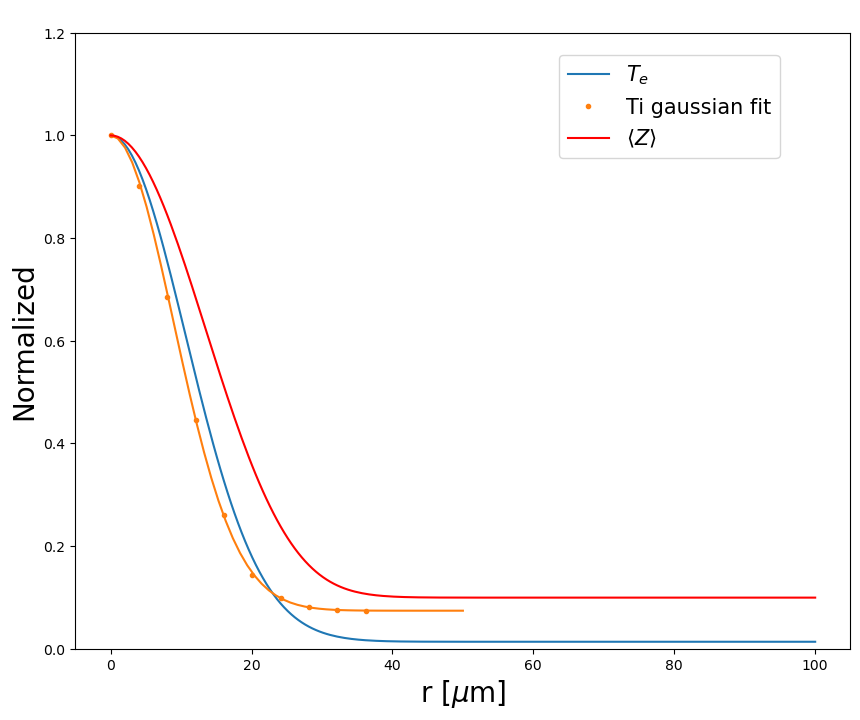

In [9]:
#Save Data for DIH MD

fig, ax = plt.subplots(figsize=(10,8),facecolor='w')

# ax.plot(data['r[m]']*1e6, data['Te[K]']*1e-3, '--.', label='Te')
ax.plot(ttm_smt.grid.r*1e6, ttm_smt.Te/ttm_smt.Te[0], label=r'$T_e$')
ax.plot(data['r[m]']*1e6, data['Tion[K]']/data['Tion[K]'][0], '.', label='Ti gaussian fit')
rs = np.linspace(0,50)
Ti_fit=  gaussian_Ti(rs, T_peak_fit, T_room_fit, σ_fit)
ax.plot(rs,Ti_fit/Ti_fit[0] , color=colors[1])

ax.set_ylabel('T [kK]',fontsize=20)

ax.set_xlabel(r'r [$\mu$m]',fontsize=20)
# ax.set_ylim(0,25)
# ax.yaxis.label.set_color(colors[0])
# ax.tick_params(axis='y', colors=colors[0])

ax.plot(ttm_smt.grid.r*1e6, ttm_smt.Zbar/ttm_smt.Zbar[0], 'r-', label=r'$\langle Z \rangle $')
ax.set_ylabel('Normalized',fontsize=20)
ax.set_ylim(0,1.2)
fig.legend(loc=(0.65,0.78), fontsize=15)